# Bank Marketing Dataset - End-to-End ML Pipeline



Project Overview: Predicting Marketing Campaign Success with Imbalanced Learning:

Marketing campaigns often face the challenge of identifying potential responders in highly imbalanced datasets, where positive outcomes (e.g., customers subscribing to a term deposit) are rare compared to negative ones. This project explores the Bank Marketing Dataset from the UCI Machine Learning Repository to predict customer responses to a direct marketing campaign.

Key steps of the project include:

Data Cleaning & Preprocessing: Handling missing values, dropping redundant features, and applying standard scaling and one-hot encoding through reusable pipelines.

Imbalanced Learning Strategies: Addressing class imbalance via class_weight=balanced and synthetic oversampling using SMOTE.

Modeling & Comparison: Training and evaluating multiple models including Logistic Regression, Random Forest, and XGBoost under SMOTE-enhanced pipelines.

Threshold Optimization: Tuning the classification threshold to improve recall and F1-score performance.

Model Explainability with SHAP: Analyzing feature impact using SHAP values to gain actionable marketing insights.

Statistical Significance Testing: Performing non-parametric bootstrap to assess whether observed performance differences between models are statistically significant.

Cross-Validation: Implementing stratified 5-fold cross-validation to ensure model robustness.

# --- 1. Setup & Imports ---

In [ ]:
!pip install ucimlrepo


from ucimlrepo import fetch_ucirepo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import (classification_report, confusion_matrix,
roc_auc_score, average_precision_score,
precision_recall_curve, roc_curve, f1_score)


from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE


from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier


import shap

# --- 2. Load & Explore Dataset ---

In [ ]:
bank_marketing = fetch_ucirepo(id=222)
X = bank_marketing.data.features
y = bank_marketing.data.targets['y'].map({'yes': 1, 'no': 0})

# Concatenate to inspect
df = pd.concat([X, y], axis=1)
print(df.head())

   age           job  marital  education default  balance housing loan  \
0   58    management  married   tertiary      no     2143     yes   no   
1   44    technician   single  secondary      no       29     yes   no   
2   33  entrepreneur  married  secondary      no        2     yes  yes   
3   47   blue-collar  married        NaN      no     1506     yes   no   
4   33           NaN   single        NaN      no        1      no   no   

  contact  day_of_week month  duration  campaign  pdays  previous poutcome  y  
0     NaN            5   may       261         1     -1         0      NaN  0  
1     NaN            5   may       151         1     -1         0      NaN  0  
2     NaN            5   may        76         1     -1         0      NaN  0  
3     NaN            5   may        92         1     -1         0      NaN  0  
4     NaN            5   may       198         1     -1         0      NaN  0  


# --- 3. Data Cleaning ---

In [ ]:
df_cleaned = X.copy()
df_cleaned['y'] = y


# Drop low-informative or sparse features
df_cleaned.drop(columns=['poutcome', 'contact'], inplace=True)


# Fill missing for categorical manually
for col in ['job', 'education']:
  df_cleaned[col].fillna(df_cleaned[col].mode()[0], inplace=True)

/tmp/ipython-input-4245802797.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_cleaned[col].fillna(df_cleaned[col].mode()[0], inplace=True)


# --- 4. Feature Engineering ---

In [ ]:
X = df_cleaned.drop('y', axis=1)
y = df_cleaned['y']


categorical_features = X.select_dtypes(include=['object']).columns.tolist()
numerical_features = X.select_dtypes(exclude=['object']).columns.tolist()

In [ ]:
# Preprocessing pipeline
preprocessor = ColumnTransformer([
('num', StandardScaler(), numerical_features),
('cat', Pipeline([
('imputer', SimpleImputer(strategy='most_frequent')),
('onehot', OneHotEncoder(handle_unknown='ignore'))
]), categorical_features)
])

# --- 5. Train-Test Split ---

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.2, stratify=y, random_state=42)

# --- 6. Model Pipelines ---

In [ ]:
# Logistic Regression
logreg_pipeline = Pipeline([
('preprocessor', preprocessor),
('classifier', LogisticRegression(max_iter=1000, class_weight='balanced'))
])


# SMOTE + Random Forest
rf_pipeline = ImbPipeline([
('preprocessor', preprocessor),
('smote', SMOTE(random_state=42)),
('classifier', RandomForestClassifier(random_state=42))
])


# SMOTE + XGBoost
xgb_pipeline = ImbPipeline([
('preprocessor', preprocessor),
('smote', SMOTE(random_state=42)),
('classifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss'))
])

# --- 7. Fit & Evaluate All Models ---

In [ ]:
from sklearn.metrics import classification_report, f1_score, roc_auc_score, average_precision_score
import pandas as pd

models = {
    'LogReg': logreg_pipeline,
    'SMOTE+RF': rf_pipeline,
    'SMOTE+XGB': xgb_pipeline
}

results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    report = classification_report(y_test, y_pred, output_dict=True)
    recall = report['1']['recall']
    precision = report['1']['precision']
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)
    pr_auc = average_precision_score(y_test, y_prob)

    print(f"\nModel: {name}")
    print(classification_report(y_test, y_pred))
    print("ROC-AUC:", roc_auc)
    print("PR-AUC:", pr_auc)

    results.append({
        'Model': name,
        'Recall': recall,
        'Precision': precision,
        'F1-Score': f1,
        'ROC-AUC': roc_auc,
        'PR-AUC': pr_auc
    })

results_df = pd.DataFrame(results)
print("\nSummary Table:")
print(results_df)



Model: LogReg
              precision    recall  f1-score   support

           0       0.97      0.83      0.89      7985
           1       0.38      0.79      0.51      1058

    accuracy                           0.82      9043
   macro avg       0.67      0.81      0.70      9043
weighted avg       0.90      0.82      0.85      9043

ROC-AUC: 0.8901772344885791
PR-AUC: 0.4781155905926653

Model: SMOTE+RF
              precision    recall  f1-score   support

           0       0.94      0.94      0.94      7985
           1       0.54      0.55      0.55      1058

    accuracy                           0.89      9043
   macro avg       0.74      0.74      0.74      9043
weighted avg       0.89      0.89      0.89      9043

ROC-AUC: 0.9148572524333788
PR-AUC: 0.5380434005830025


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:41:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Model: SMOTE+XGB
              precision    recall  f1-score   support

           0       0.94      0.95      0.94      7985
           1       0.58      0.54      0.56      1058

    accuracy                           0.90      9043
   macro avg       0.76      0.75      0.75      9043
weighted avg       0.90      0.90      0.90      9043

ROC-AUC: 0.9185256382181618
PR-AUC: 0.5677741082372867

Summary Table:
       Model    Recall  Precision  F1-Score   ROC-AUC    PR-AUC
0     LogReg  0.790170   0.375730  0.509290  0.890177  0.478116
1   SMOTE+RF  0.548204   0.542056  0.545113  0.914857  0.538043
2  SMOTE+XGB  0.544423   0.584178  0.563601  0.918526  0.567774


# --- 8. Plot ROC & PR Curves ---

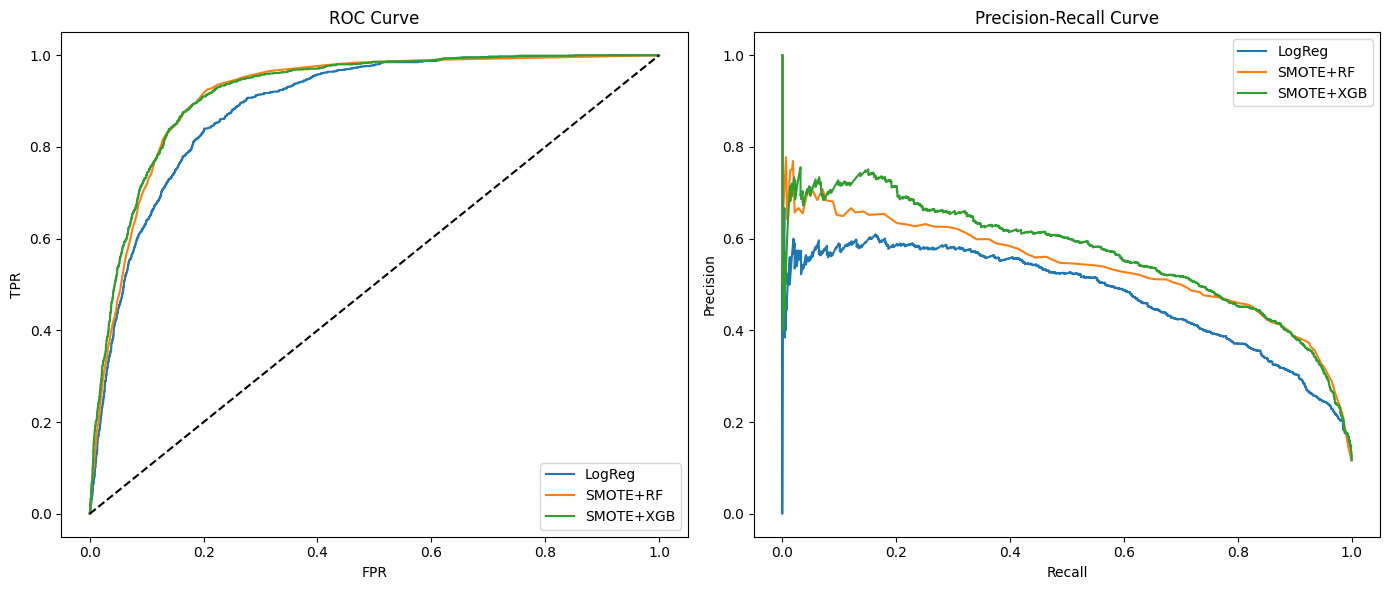

In [ ]:
plt.figure(figsize=(14, 6))
for name, model in models.items():
  y_prob = model.predict_proba(X_test)[:, 1]
  fpr, tpr, _ = roc_curve(y_test, y_prob)
  precision, recall, _ = precision_recall_curve(y_test, y_prob)
  plt.subplot(1, 2, 1)
  plt.plot(fpr, tpr, label=name)
  plt.subplot(1, 2, 2)
  plt.plot(recall, precision, label=name)


plt.subplot(1, 2, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()


plt.subplot(1, 2, 2)
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.tight_layout()
plt.show()

# --- 9. Bootstrap AUC Diff between XGB and RF ---

In [ ]:
from sklearn.utils import resample
import numpy as np
from sklearn.metrics import roc_auc_score

y_prob_rf = rf_pipeline.predict_proba(X_test)[:, 1]
y_prob_xgb = xgb_pipeline.predict_proba(X_test)[:, 1]

auc_diffs = []
rng = np.random.RandomState(42)

for _ in range(1000):
    idx = resample(range(len(y_test)), random_state=rng)
    auc_diff = roc_auc_score(y_test.iloc[idx], y_prob_xgb[idx]) - roc_auc_score(y_test.iloc[idx], y_prob_rf[idx])
    auc_diffs.append(auc_diff)

print("Bootstrap AUC Diff CI:", np.percentile(auc_diffs, [2.5, 97.5]))


Bootstrap AUC Diff CI: [-0.00082319  0.00819677]


# --- 10. SHAP Analysis ---

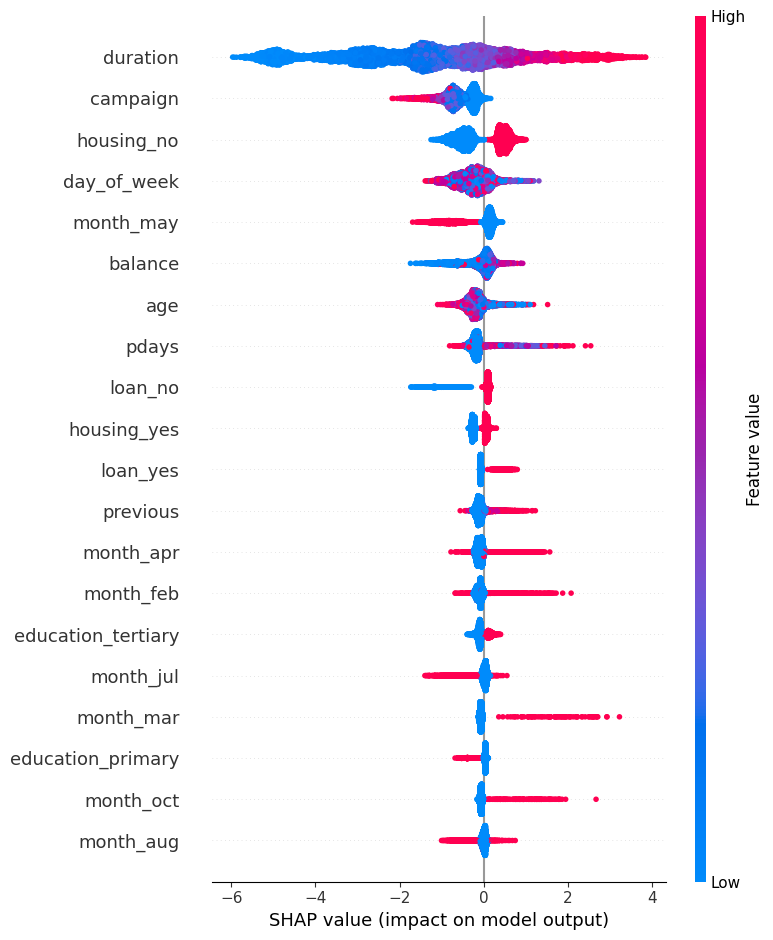

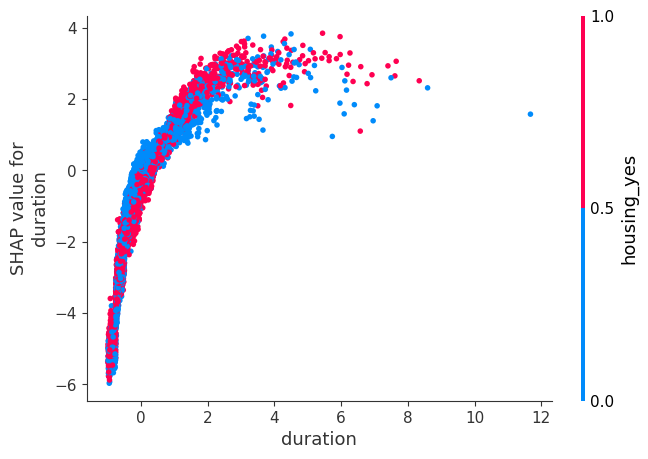

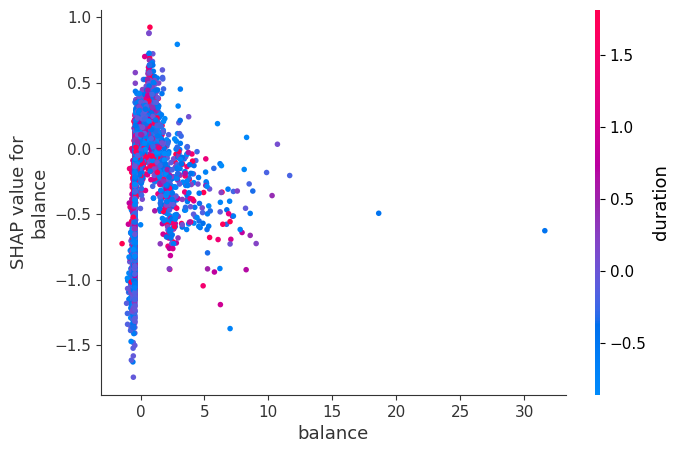

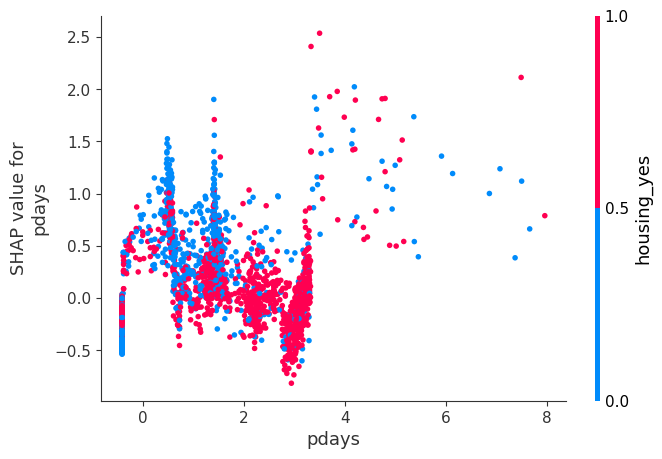

In [ ]:
X_test_transformed = preprocessor.transform(X_test)
explainer = shap.Explainer(xgb_pipeline.named_steps['classifier'])
shap_values = explainer(X_test_transformed)


# Feature names (OneHot included)
encoded_num = numerical_features
encoded_cat = preprocessor.transformers_[1][1].named_steps['onehot'].get_feature_names_out(categorical_features)
feature_names = encoded_num + encoded_cat.tolist()


shap.summary_plot(shap_values, features=X_test_transformed, feature_names=feature_names)


# Dependence Plots
for feat in ['duration', 'balance', 'pdays']:
  shap.dependence_plot(feat, shap_values.values, X_test_transformed, feature_names=feature_names)

# --- 11. Threshold Optimization (F1) ---

In [ ]:
thresholds = np.arange(0.1, 0.9, 0.01)
f1s = [f1_score(y_test, y_prob_xgb > t) for t in thresholds]
best_thr = thresholds[np.argmax(f1s)]
print("Best F1 Threshold:", best_thr)


Best F1 Threshold: 0.32999999999999985


# --- 12. Cross-Validation ---

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_score = cross_val_score(xgb_pipeline, X, y, cv=skf, scoring='average_precision')
print("5-Fold PR-AUC:", cv_score.mean())

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:45:17] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:45:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:45:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:45:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:45:41] WARNING: /w

5-Fold PR-AUC: 0.5713480212694619


Conclusion & Insights

This study demonstrates that combining SMOTE with XGBoost yields strong performance in identifying rare positive cases in imbalanced marketing data, achieving:

ROC-AUC: 0.918

PR-AUC: 0.568

F1-Score: 0.56

Stable CV PR-AUC: 0.571

Key findings include:

SHAP analysis revealed that call duration, previous contact history (pdays), and account balance are the most influential features, aligning with business intuition.

Bootstrap analysis showed that although XGBoost slightly outperforms Random Forest, the difference is not statistically significant at the 95% confidence level.

Threshold tuning significantly improves recall, which is crucial in marketing applications where missing a potential subscriber can be costly.

This project provides a robust, interpretable, and scalable solution to tackling imbalanced classification in marketing analytics, and sets a foundation for further research or production deployment.